# News Aggregator

## NLP: Topic Modelling

### Keys Concepts
- Latent Dirichlet Allocation
- Latent Semantic Analysis

In [2]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

# Iteratively read files
import glob
import os

# For displaying images in ipython
from IPython.display import HTML, display

In [3]:
% matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14.0, 8.7)
#warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

### Load data

In [4]:
# User defined function to read and store bbc data from multipe folders
def load_data(folder_names,root_path):
    fileNames = [path + '/' + 'bbc' +'/'+ folder + '/*.txt' for path,folder in zip([root_path]*len(folder_names),
                                                                               folder_names )]
    doc_list = []
    tags = folder_names
    for docs in fileNames:
        #print(docs)
        #print(type(docs))
        doc = glob.glob(docs) # glob method iterates through the all the text documents in a folder
        for text in doc:
            with open(text, encoding='latin1') as f:
                topic = docs.split('/')[8]

                lines = f.readlines()
                heading = lines[0].strip()
                body = ' '.join([l.strip() for l in lines[1:]])
                doc_list.append([topic, heading, body])
        print("Completed loading data from folder: %s"%topic)
    
    print("Completed Loading entire text")
    
    return doc_list

In [5]:
folder_names = ['business','entertainment','politics','sport','tech']
docs = load_data(folder_names = folder_names, root_path = os.getcwd())

Completed loading data from folder: business
Completed loading data from folder: entertainment
Completed loading data from folder: politics
Completed loading data from folder: sport
Completed loading data from folder: tech
Completed Loading entire text


In [6]:
docs = pd.DataFrame(docs, columns=['Category', 'Heading', 'Article'])
print(docs.head())
print('\nShape of data is {}\n'.format(docs.shape))
print(docs.info())

   Category                            Heading  \
0  business    UK economy facing 'major risks'   
1  business  Aids and climate top Davos agenda   
2  business   Asian quake hits European shares   
3  business   India power shares jump on debut   
4  business    Lacroix label bought by US firm   

                                             Article  
0   The UK manufacturing sector will continue to ...  
1   Climate change and the fight against Aids are...  
2   Shares in Europe's leading reinsurers and tra...  
3   Shares in India's largest power producer, Nat...  
4   Luxury goods group LVMH has sold its loss-mak...  

Shape of data is (2225, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
Category    2225 non-null object
Heading     2225 non-null object
Article     2225 non-null object
dtypes: object(3)
memory usage: 52.2+ KB
None


<h2>Latent Dirichlet Allocation</h2>
<h3>From Documents -- DTM -- LDA Model</h3>

Topic modeling aims to automatically summarize large collections of documents to facilitate organization and management, as well as search and recommendations. At the same time, it can enable the understanding of documents to the extent that humans can interpret the descriptions of topics

<img src="images/lda2.png" alt="lda" style="width:60%">
<img src="images/docs_to_lda.png" alt="ldaflow" style="width:100%">

## Find Topics in Documents and group them: First Step to Build News Aggregator

### Convert Raw text --> Parsed Text --> Document Term Matrix --> Topic Models --> Extract Topics

### How Topic Modelling Works

LDA  assumes topics are probability distributions over words, and documents are distributions over topics. Which implies that documents cover only a small set of topics, and topics use only a small set of words frequently.

__The Mathematical Formula:__

<img src="images/ldaformula.png" alt="ldaflow" style="width:100%">


### Important Reading Article on Topic Models
https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d

In [7]:
# Split Data to train & test Topic Models
train_docs, test_docs = train_test_split(docs, 
                                         stratify=docs.Category, 
                                         test_size=50, 
                                         random_state=42)

In [8]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [9]:
vectorizer = TfidfVectorizer(max_df=.2, 
                             min_df=.01, 
                             stop_words='english')

train_dtm = vectorizer.fit_transform(train_docs["Article"])
words = vectorizer.get_feature_names()
train_dtm

<2175x2902 sparse matrix of type '<class 'numpy.float64'>'
	with 205355 stored elements in Compressed Sparse Row format>

In [11]:
len(words)

2902

### Assign Number of Topics to be extracted

In [12]:
n_components = 6
topic_labels = ['Topic {}'.format(i) for i in range(1, n_components+1)]

In [13]:
topic_labels

['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6']

In [14]:
lda_base = LatentDirichletAllocation(n_components=n_components,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     max_iter=10)
lda_base.fit(train_dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=6, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [15]:
# Save the model on disk
joblib.dump(lda_base,'lda_10_iter.pkl')

['lda_10_iter.pkl']

### Explore topics & word distributions

In [16]:
# pseudo counts
topics_count = lda_base.components_
print(topics_count.shape)
topics_count[:5]

(6, 2902)


array([[ 6.08625729,  2.85305349,  0.97735905, ...,  0.54219725,
        11.56358758,  0.39475439],
       [ 8.07085659,  6.610597  ,  1.53044947, ...,  2.61538921,
         0.16672666,  0.41393311],
       [ 3.99716828,  0.59439677,  0.5300671 , ...,  0.18350263,
         0.16666761,  0.41539545],
       [ 3.07069478,  0.79464517,  0.16771351, ...,  0.30762383,
         0.1666674 ,  4.98079742],
       [ 0.16668561,  0.16669228,  0.16669049, ...,  0.16670751,
         0.16667072,  0.16670902]])

In [17]:
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
10,0.00,0.00,0.00,0.00,0.00,0.00
100,0.00,0.00,0.00,0.00,0.00,0.00
100m,0.00,0.00,0.00,0.00,0.00,0.00
11,0.00,0.00,0.00,0.00,0.00,0.00
12,0.00,0.00,0.00,0.00,0.00,0.00


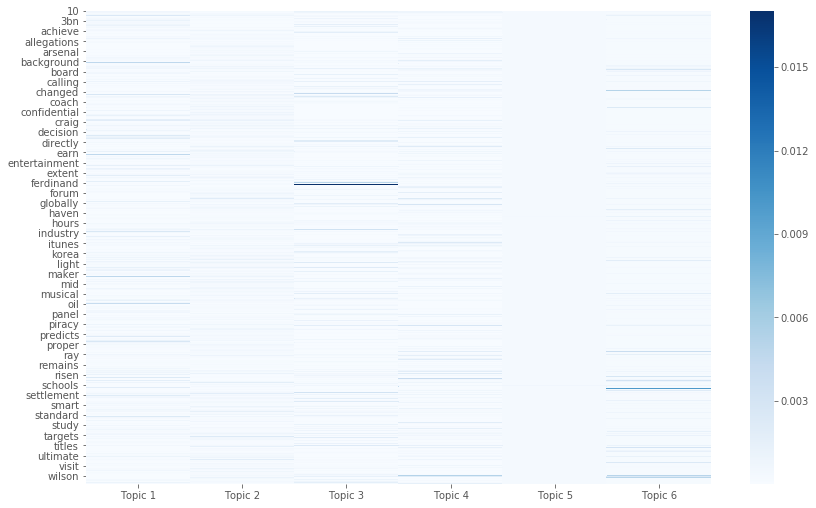

In [18]:
sns.heatmap(topics, cmap='Blues')

In [30]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(20).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
0,company,labour,film,game,sullivan,seed
1,growth,party,best,england,scott,champion
2,market,election,award,club,yes,open
3,economy,blair,awards,cup,hide,australian
4,bank,mobile,band,team,directed,indoor
5,sales,brown,star,win,isn,olympic
6,firm,technology,music,players,fellow,best
7,oil,minister,album,match,bernard,won
8,shares,says,actor,chelsea,win,championships
9,economic,use,films,injury,matters,win


### Evaluate Fit on Train Set

In [20]:
train_preds = lda_base.transform(train_dtm)
train_preds.shape

(2175, 6)

In [21]:
t = train_preds[0:5]
print(t)
np.argmax(t,axis =1)

[[0.01983265 0.89855273 0.02291245 0.01962864 0.01949379 0.01957974]
 [0.01219668 0.93971161 0.01202035 0.01206296 0.01198505 0.01202336]
 [0.01896571 0.0189469  0.77650714 0.02478965 0.01870638 0.14208422]
 [0.9107756  0.01799608 0.01768665 0.01869484 0.01708069 0.01776613]
 [0.01732937 0.01805871 0.01732493 0.9130866  0.01707726 0.01712313]]


array([1, 1, 2, 0, 3])

In [22]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.Category)
train_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
Category,,,,,,
entertainment,0.02,0.90,0.02,0.02,0.02,0.02
tech,0.01,0.94,0.01,0.01,0.01,0.01
entertainment,0.02,0.02,0.78,0.02,0.02,0.14
business,0.91,0.02,0.02,0.02,0.02,0.02
sport,0.02,0.02,0.02,0.91,0.02,0.02


In [ ]:
train_eval.groupby(level='Category').mean().plot.bar(title='Avg. Topic Probabilities')

Text(0.5,1,'Train Data: Topic Assignments')

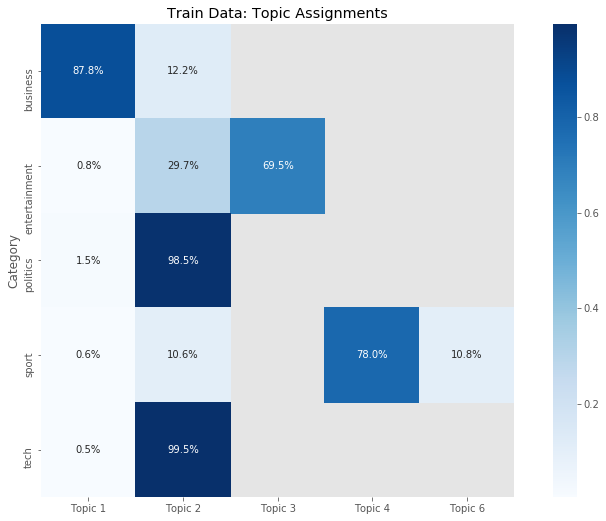

In [23]:
df = train_eval.groupby(level='Category').idxmax(
    axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='Category').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Train Data: Topic Assignments')

### Evaluate Fit on Test Set

In [24]:
test_dtm = vectorizer.transform(test_docs.Article)
test_dtm

<50x2902 sparse matrix of type '<class 'numpy.float64'>'
	with 4418 stored elements in Compressed Sparse Row format>

In [25]:
test_preds = lda_base.transform(test_dtm)
test_eval = pd.DataFrame(test_preds, columns=topic_labels, index=test_docs.Category)
test_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
Category,,,,,,
entertainment,0.22,0.71,0.02,0.02,0.02,0.02
tech,0.02,0.91,0.02,0.02,0.02,0.02
tech,0.02,0.77,0.17,0.02,0.02,0.02
business,0.81,0.12,0.02,0.02,0.02,0.02
sport,0.02,0.02,0.22,0.58,0.02,0.15


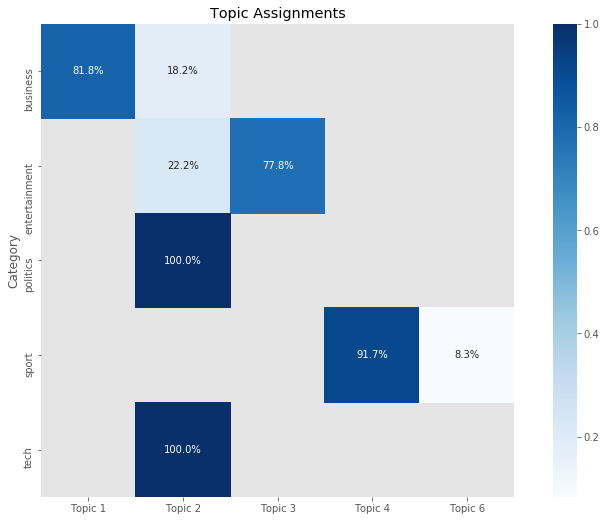

In [26]:
df = test_eval.groupby(level='Category').idxmax(
    axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='Category').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Topic Assignments');

In [27]:
# Create Training Dataframe for Comparing Misclassified documents
train_opt_eval = pd.DataFrame(data=lda_base.transform(train_dtm),
                              columns=topic_labels,
                              index=train_docs.Category)

In [28]:
test_opt_eval = pd.DataFrame(data=lda_base.transform(test_dtm),
                              columns=topic_labels,
                              index=test_docs.Category)

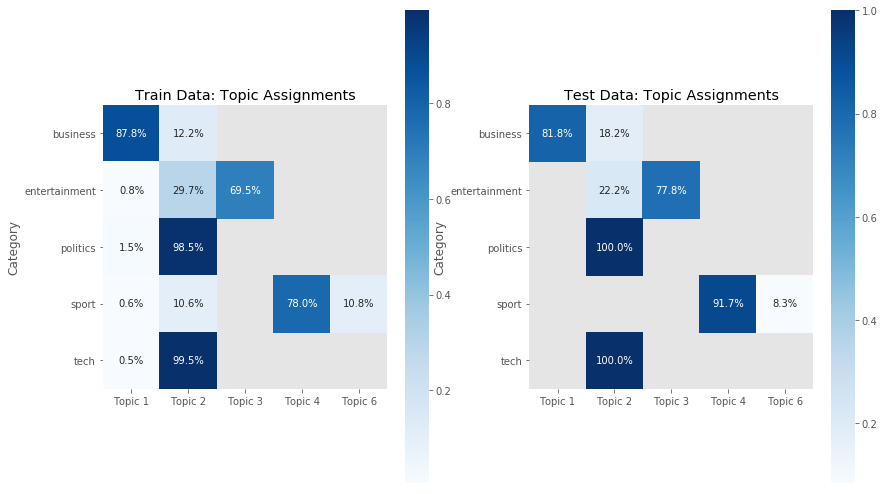

In [29]:
## Comparing Side by Side
fig, axes = plt.subplots(ncols=2)
source = ['Train', 'Test']
for i, df in enumerate([train_opt_eval, test_opt_eval]):
    df = df.groupby(level='Category').idxmax(
    axis=1).reset_index(-1, drop=True)
    sns.heatmap(df.groupby(level='Category').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True, ax=axes[i])
    axes[i].set_title('{} Data: Topic Assignments'.format(source[i]));

### Misclassified Documents

In [ ]:
test_assignments = test_opt_eval.groupby(level='Category').idxmax(axis=1)
test_assignments = test_assignments.reset_index(-1, drop=True).to_frame('predicted').reset_index()
test_assignments['heading'] = test_docs.Heading.values
test_assignments['Article'] = test_docs.Article.values
test_assignments.head()